# EEE 443 - Final Project - Image Captioning

## Group 12:

Atakan Topcu, Ata Korkusuz, Ata Yavuzyılmaz, Dora Tütüncü

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sn
import requests
from PIL import Image
import os 
import requests
import pandas as pd
file_train="eee443_project_dataset_train.h5"

### Next Step:
We first create function to read from the given h5 file.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def Dataset_Read(file_train):
    '''
    Funtction to read given h5 train file
    '''
    f = h5py.File(file_train, 'r') #Load Data
    print("Keys: %s" % list(f.keys()))
    train_cap = f['train_cap'][()] #Captions for training images (contains 17 indices from the vocabulary for each image
    train_imid = f['train_imid'][()] #The indices of training images (since a single image can be captioned several times
    train_url = f['train_url'][()] #Flickr URLs for training images 
    word_code = f['word_code'][()] #Dictionary for converting words to vocabulary indices
    train_ims = None  #Do not use train_ims. Otherwise, score is halved!!
    print("Size of captions: ",train_cap.shape)
    print("Size of indices of training images: ",train_imid.shape[0])
    print("Size of URL: ",train_url.shape[0])
    print("Size of Dictionary: ",word_code.shape[0])
    return train_imid, train_cap, train_url, word_code

def Test_Read(file_test):
    '''
    Funtction to read given h5 test file
    '''
    f = h5py.File(file_test, 'r') #Load Data
    print("Keys: %s" % list(f.keys()))
    test_caps = f['test_caps'][()] #Captions for test images (contains 17 indices from the vocabulary for each image
    test_imid = f['test_imid'][()] #The indices of test images (since a single image can be captioned several times
    test_url = f['test_url'][()] #Flickr URLs for test images
    test_ims = None  #Do not use test_ims. Otherwise, score is halved!!
    print("Size of captions: ", test_caps.shape)
    print("Size of indices of test images: ", test_imid.shape[0])
    print("Size of URL: ", test_url.shape[0])
    return test_imid, test_caps, test_url

### Next Step:
We create a new directory for downloading the images from the Flickr URL addresses. Also verification method is implemented. We look at two factors for images that will be used in the project:

1. HTTP Status Code (Needs to be 200)
2. JPEG Format


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#root_dir = os.getcwd()
direc='C:\\Users\\ataka\\Desktop\\EEE443_Proje' #Change accordingly
imgs_dir = direc + '\\Downloaded_Ims'
exports_dir = direc + '\\Exported_Ims'

def Download(directory,file):
    """
    Function to save images from given urls
    """
    os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    train_imid,train_cap,train_url,word_code=Dataset_Read(file_train)
    if not os.path.exists(directory): #Create the directory if it does not exist in the first place.
        os.makedirs(directory)
    os.chdir(directory)
    print('Current working directory: ', os.getcwd()) #Check
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0'}#Change accordingly
    for URL in range(len(train_url)):
        url = train_url[URL].decode('utf-8')
        response = requests.get(url, allow_redirects=True, stream=True, headers=headers)
        #If HTTP 200 is achieved, write file
        if response.status_code == 200:
            with open(directory+ '/' + str(URL), 'wb') as outfile:
                    outfile.write(response.content)
    
    os.chdir('..')
    print('Current working directory: ', os.getcwd())#Check     

    return 

In [ ]:
def Image_Verification(directory,train_url):
    os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    os.chdir(directory)
    corrupt_index = []
    d_index=[]
    print('Current working directory: ', os.getcwd()) #Check
    for URL in range(len(train_url)):
        try:
            img = Image.open(directory + '/' + str(URL))
            if img.format == 'JPEG':
                continue
            else:
                print('Invalid image type, not JPEG')
                corrupt_index.append(directory + '\\' + str(URL))
                d_index.append(URL)
        except:
            continue
    os.chdir('..')
    print('Current working directory: ', os.getcwd())#Check  
    # Take note of the problematic image files
    with open('D_Ims.txt', 'w') as txt_file:
        for items in corrupt_index:
            txt_file.write('%s\n' % items)
    return d_index

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/EE443 Project')
train_imid,train_cap,train_url,word_code=Dataset_Read(file_train)
#Del_index=Image_Verification(imgs_dir,train_url)

Keys: ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']
Size of captions:  (400135, 17)
Size of indices of training images:  400135
Size of URL:  82783
Size of Dictionary:  1


### Next Step:

We start implementing the transfer model. In our case, we will be using Inception Resnet V2. Other models can also be used such as Inception v3 or VGGA16. In order to extract features using such models, consider two factors:

1. Input Size: Input size must be (255,255,3) for the Inception Resnet V2 model. Thus, you have to preprocess your images.
2. Get rid of the final layer in your model. We want the pre-Trained Model as Feature Extractor Preprocessor. Thus, you have to get rid of the last layer as it is used for the original classification task.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
from tensorflow.keras.preprocessing import image 


"""
Target Model:

            InceptionResNetV2(
                include_top=True, weights='imagenet', input_tensor=None,
                input_shape=None, pooling=None, classes=1000,
                classifier_activation='softmax', **kwargs
            )
"""

#If time allows different methods can also be utilized such as VGG16.    
def Feature_Extraction_Model(): 
    tf.keras.backend.clear_session() # clears previous session if this code is run multiple time
    #Pre-Trained Model as Feature Extractor Preprocessor
    ResNet = InceptionResNetV2(include_top=True, weights='imagenet', input_shape=(299,299,3))
    ResNet.trainable = False
    ResNet = tf.keras.Model(ResNet.input, ResNet.layers[-2].output)# remove the output layer
    return ResNet

def ImageEncoding(directory, imageIndex,model):
    #Process images so that they can be inputted in the model correctly.
    img = tf.io.read_file(directory+imageIndex)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.expand_dims(img, axis=0)
    #print(img.shape)
    img = preprocess_input(img)
    encoding = model.predict(img) #Extracts features into single 2D vector.
    #print(encoding.shape) 
    return encoding    #Should be of size (1,1536)


### Next Step:

In this step, we define the final function for creating the encoded features using our transfer model. There are three factors to consider:

1. Problematic Files: Previously, we have defined problematic non-JPEG files in a .txt file of our main directory. Before you start encoding, you have to make sure these files are not used in the process for the sake of performance and reliability.

2. Iteratively, you will go through each file in the train directory and start encoding. You will return a list called Encoded_Features which will be used in future.

3. ***Never stack model:*** This is extremely important. You should define the model outside of the Create_Features function. Otherwise, it will stack up in the for loop and it will take significant time (days) to compile the images.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from tqdm import tqdm
def Create_Features(directory,model):
    #os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    txt_file=open('D_Ims.txt', 'r') #If you named the .txt file differently, change accordingly.
    Problem_files=txt_file.readlines()#Read the problematic file names.
    
    os.chdir(directory) #Change to training directory!
    print(os.getcwd())#Check
    Encoded_Features = []
    for img in tqdm(os.listdir()): #Scans the directory. img is a string!
        check=os.getcwd()+'\\'+img+'\n'
        if not Problem_files.count(check): 
            tmp = ImageEncoding(os.getcwd()+ '\\',img, model)
            Encoded_Features.append(tmp)
        else:
            print("Warning:non_JPEG format detected. It will not be used!")

    Encoded_Features=np.array(Encoded_Features)
    Encoded_Features=Encoded_Features.reshape(Encoded_Features.shape[0],Encoded_Features.shape[2])
    return Encoded_Features #Should output (x,1536) where x is the number of samples.



In [ ]:
os.getcwd()

'/content'

In [ ]:
model=Feature_Extraction_Model() #ResNetv2 Model has been created using the previous function
imgs_dir = "/Test_Ims"
Encoded_Features=Create_Features(imgs_dir,model) #Will take some time! Progress bar gives a better estimate of the current state of the fucntion.

### Next Step:

We don't want to start this encoding process over and over as it will take time. Thus, save it as pickle file and load it later when needed.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pickle #Call the function


In [ ]:
os.chdir(imgs_dir)
Index=[]
for img in tqdm(os.listdir()): #Scans the directory. img is a string!
        check=os.getcwd()+'\\'+img+'\n'
        if not Problem_files.count(check): 
            Index.append(img)

In [ ]:
print('Encoding finished. Pickling.')
if not os.path.exists(exports_dir): #Create the directory if it does not exist in the first place.
        os.makedirs(exports_dir)
os.chdir(exports_dir)

# save to file
print(Encoded_Features.shape)
pickle.dump(Encoded_Features, open('Feature_Encodes.pkl', 'wb'))
pickle.dump(Index, open('Feature_Index.pkl', 'wb'))


os.chdir(direc) # return back to the main directory

### Check GPU Availability:

Tensorflow might cause problem in enabling GPU usage since it requires many packages to be downloaded (CUDA, cuDNN, etc.). Thus, I recommend using Google Collab as it eases this operation. If you are not using Google Collab, you should check the compability of cuDNN and CUDA first as the newest vesions are not backwards compatible

**Collab --->Edit ---> Notebook Settings ---> Hardware Accelerator ---> GPU ---> Save**

For Local Jupyter Application, follow the link for setting up CUDA and cuDNN on your environment path.

https://towardsdatascience.com/installing-tensorflow-with-cuda-cudnn-and-gpu-support-on-windows-10-60693e46e781


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU'))==0:
  print("Warning: Need to Enable GPU")
else:
  print((tf.config.list_physical_devices('GPU')))

#Should enable GPU. Otherwise, project will take time.

GPUs Available:  0


### Load Pickle File Again
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pickle
print(os.getcwd())
os.chdir("Exported_Ims")
print(os.getcwd())
print(os.listdir())

/content/drive/.shortcut-targets-by-id/1q5ddm2nUEhnXiE24B5oUKki96KGwYzAB/EE443 Project
/content/drive/.shortcut-targets-by-id/1q5ddm2nUEhnXiE24B5oUKki96KGwYzAB/EE443 Project/Exported_Ims
['Feature_Index.pkl', 'Feature_Encodes.pkl', 'Train_Encodes.pkl', 'Train_Captions.pkl', 'Validation_Encodes.pkl', 'Validation_Captions.pkl']


In [ ]:
Feature_Encodes = pickle.load(open(exports_dir + "\\Feature_Encodes.pkl",'rb'), encoding='utf8')
Feature_Index = pickle.load(open(exports_dir + "\\Feature_Index.pkl",'rb'), encoding='utf8')
print(Feature_Encodes.shape)
Feature_Index=np.array(Feature_Index)
print(Feature_Index.shape)

(71648, 1536)
(71648,)


### Extract Word Dictionary Along with Creating Functions for Captioning
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Export Word Dictionary. Size should be 1004!
os.chdir("/content/drive/MyDrive/EE443 Project")
_,_,_,word_code=Dataset_Read(file_train)
Words = pd.DataFrame(word_code)
Words = Words.sort_values(0, axis=1)
word_columns = np.asarray(Words.columns)
wordDict = {}
for i in range(len(word_columns)):
  word = word_columns[i]
  wordDict[i] = word
print('Size of Extracted Word Dictionary: ', len(wordDict.keys()))


def Caption_string(caption_array):
    """
    Format caption numpy array to a list of string(s).
    """
    
    Captions_list = []
    caption = ""
    for caps in caption_array:
        for word in caps:
            if (word == 'x_NULL_') or (word == 'x_START_') or (word == 'x_END_'):
                continue #Don't count x_NULL, x_Start and x_END
            elif (word == 'x_UNK_'):
                word = 'UNKNOWN'
            caption += word + " "

        Captions_list.append(caption.strip()) #Remove spaces and append
        caption = ""
    return Captions_list


def get_key(val,dictionary): # Function to return key for any value
    for key, value in dictionary.items():
         if val == value:
             return key

Keys: ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']
Size of captions:  (400135, 17)
Size of indices of training images:  400135
Size of URL:  82783
Size of Dictionary:  1
Size of Extracted Word Dictionary:  1004


In [ ]:
wordDict

{0: 'x_NULL_',
 1: 'x_START_',
 2: 'x_END_',
 3: 'x_UNK_',
 4: 'a',
 5: 'on',
 6: 'of',
 7: 'the',
 8: 'in',
 9: 'with',
 10: 'and',
 11: 'is',
 12: 'man',
 13: 'to',
 14: 'sitting',
 15: 'an',
 16: 'two',
 17: 'standing',
 18: 'at',
 19: 'people',
 20: 'are',
 21: 'next',
 22: 'white',
 23: 'woman',
 24: 'table',
 25: 'street',
 26: 'that',
 27: 'holding',
 28: 'person',
 29: 'large',
 30: 'some',
 31: 'it',
 32: 'down',
 33: 'top',
 34: 'group',
 35: 'field',
 36: 'up',
 37: 'small',
 38: 'near',
 39: 'tennis',
 40: 'his',
 41: 'front',
 42: 'black',
 43: 'plate',
 44: 'room',
 45: 'train',
 46: 'riding',
 47: 'dog',
 48: 'red',
 49: 'young',
 50: 'by',
 51: 'cat',
 52: 'water',
 53: 'baseball',
 54: 'has',
 55: 'xWhile',
 56: 'walking',
 57: 'playing',
 58: 'bathroom',
 59: 'sign',
 60: 'blue',
 61: 'food',
 62: 'kitchen',
 63: 'grass',
 64: 'bus',
 65: 'there',
 66: 'parked',
 67: 'pizza',
 68: 'green',
 69: 'side',
 70: 'other',
 71: 'building',
 72: 'looking',
 73: 'snow',
 74: '

In [ ]:
import pickle

pickle.dump(wordDict, open("ixtoword.pkl", 'wb'))

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1q5ddm2nUEhnXiE24B5oUKki96KGwYzAB/EE443 Project'

In [ ]:
def Fetch_Caption(image_id, imid, cap, word_dict):
    """
    A function which returns the caption of an image wrt. its ID
    """
    # Query this on train_imid to extract which indices hold the captions for this image:
    indices = np.where(imid == int(image_id))[0] #[0] removes tuple's second element which is dtype=int64
    caps = [] #Extract the caps of the specified image
    for idx in indices:
        cap1 = cap[idx][:]
        caps.append(cap1)
    #Conversion to string
    text_cap = []
    for item in caps:
        temp = []
        for word in item:
            key=get_key(word,word_dict) # Function to return key for any value
            temp.append(key)
        text_cap.append(temp)
       
    caps = [list(c) for c in caps] # list comprehension to make arrays list
    '''
    Should return something like:
    [[1, 7, 78, 240, 20, 244, 5, 7, 213, 35, 2, 0, 0, 0, 0, 0, 0], [1, 78, 240, 6, 193, 927, 244, 5, 63, 2, 0, 0, 0, 0, 0, 0, 0], [1, 30, 240, 20, 244, 5, 3, 10, 536, 3, 542, 2, 0, 0, 0, 0, 0], [1, 4, 423, 240, 244, 10, 109, 63, 8, 4, 35, 2, 0, 0, 0, 0, 0], [1, 78, 193, 3, 240, 244, 5, 7, 63, 2, 0, 0, 0, 0, 0, 0, 0]]
    '''
    return caps

# Print captions of an image
def Caption_Print(caps, word_dict):
    i = 0
    text_cap = []
    for item in caps:
        i += 1
        temp = []
        for word in item:
            key=get_key(word,word_dict)
            temp.append(key)
        text_cap.append(temp)
        # x_NULL_ strings are only ignored, not erased from the captions
    Captions_list = Caption_string(text_cap)
    for caption in range(i):
        print('Caption ', caption+1,': ',Captions_list[caption])
    return Captions_list

# !Important!

**For training data, train index yields the train index-1 image**. So, if the index is 314, the train image should be 313!!. 

**For Test data, train index yields the train index image**. So, if the index is 314, the test image should be 314!!. 

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Caption  1 :  the three cows are grazing on the grassy field
Caption  2 :  three cows of different colors grazing on grass
Caption  3 :  some cows are grazing on UNKNOWN and having UNKNOWN time
Caption  4 :  a few cows grazing and eating grass in a field
Caption  5 :  three different UNKNOWN cows grazing on the grass


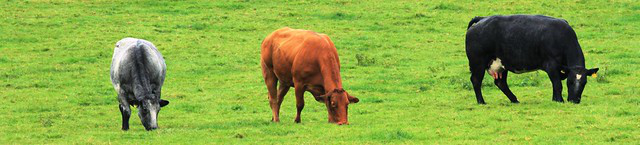

In [ ]:
#Example 
cap=Fetch_Caption(314, train_imid, train_cap, wordDict) 
Captions_list = Caption_Print(cap,wordDict)
Image.open(imgs_dir+'\\313') #Careful: We decrement the index given in Fetch_Caption!

### Sub-Divide the Training Data:
Divide your training data as 85% Training and 15% Validation data. Function will output two new dictionaries with sorted IDs.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import random
import math
Feature_Dictionary= dict(zip(Feature_Index, Feature_Encodes)) #We create dictionary from the encoded files (index,features)
def SubDivision(percentage, list_to_divide):
    indices = random.sample(list(list_to_divide.keys()), len(list_to_divide)- math.ceil((1-percentage)*len(list_to_divide)))
    Validation = {}
    Train = {}
    results = list(map(int, indices)) #Convert From String to Int for sorting
    OG=list(map(int, list_to_divide.keys()))
    results.sort(reverse=False) #Ascending Order
    rest=list(set(OG).difference(set(results)))
    rest.sort(reverse=False)
    for idx in results:
            Train[str(idx)]=(list_to_divide[str(idx)])
            
    for idv in rest:
            Validation[str(idv)]=(list_to_divide[str(idv)])
    
    return Validation, Train


In [ ]:
TRAIN_PERCENTAGE = 0.85
Validation, Train=SubDivision(TRAIN_PERCENTAGE, Feature_Dictionary)
print('Length of the Train Data:',len(Train))
print('Length of the Validation Data:',len(Validation))

Length of the Train Data: 60900
Length of the Validation Data: 10748


### Prepare the input data:

Each key with train, validation data contains keys for encoding dictionary. Each key in the encoding corresponds to a single encoded image, and each encoded image corresponds to approximately 4-5 captions.


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from tqdm.notebook import tqdm #For progress bar representation. Purely decoration purposes!
#from tqdm import tqdm #For progress bar representation

#With this dataset, we will call our previous functions for captioning.
def DataPreparation(imid, cap, KEY_Lists,  encoding_dict , word_dict):
    ENCODES = []
    CAPTIONS = []
    for key in tqdm(list(KEY_Lists.keys())): # Iteration for each key in train or validation (Could also be test dataset)
        key_captions = Fetch_Caption(key, imid, cap, word_dict)
        # Replicate encoding number of caption times.
        for i in range(len(key_captions)):
            ENCODES.append(encoding_dict[key]) #Iterate for number of captions
        
        # Process the captions:
        for c in key_captions:
            CAPTIONS.append(c)
            
    return ENCODES,CAPTIONS

In [ ]:
Train_Encodes, Train_Captions = DataPreparation(train_imid, train_cap, Train, Feature_Dictionary, wordDict)

  0%|          | 0/60900 [00:00<?, ?it/s]

In [ ]:
Validation_Encodes, Validation_Captions = DataPreparation(train_imid, train_cap, Validation, Feature_Dictionary, wordDict)

  0%|          | 0/10748 [00:00<?, ?it/s]

### Saving the Outputs:
Now that we have processed the train and validation data, we can proceed to save them in pickle file format so that they can be called in the future without any compilation.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pickle #Call the function
os.chdir(exports_dir)
print(os.getcwd())

# save to file
pickle.dump(Train_Encodes, open('Train_Encodes.pkl', 'wb'))
pickle.dump(Train_Captions, open('Train_Captions.pkl', 'wb'))

pickle.dump(Validation_Encodes, open('Validation_Encodes.pkl', 'wb'))
pickle.dump(Validation_Captions, open('Validation_Captions.pkl', 'wb'))


os.chdir(direc) # return back to the main directory

C:\Users\ataka\Desktop\EEE443_Proje\Exported_Ims


In [ ]:
print('Train Encode Shape:',np.array(Train_Encodes).shape)
print('Train Caption Shape:',np.array(Train_Captions).shape)

print('Validation Encode Shape:',np.array(Validation_Encodes).shape)
print('Validation Caption Shape:',np.array(Validation_Captions).shape)


Train Encode Shape: (294425, 1536)
Train Caption Shape: (294425, 17)
Validation Encode Shape: (51908, 1536)
Validation Caption Shape: (51908, 17)


### Load the Data Back Again:
This way, we create checkpoints where a problem occurs we can just load the file instead of compiling.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pickle #Call the function
import os
exports_dir = "/content/drive/MyDrive/EE443 Project/Exported_Ims"
os.chdir(exports_dir)
print(os.getcwd())

Train_Encodes = pickle.load(open(exports_dir + "/Train_Encodes.pkl",'rb'), encoding='utf8')
Train_Captions = pickle.load(open(exports_dir + "/Train_Captions.pkl",'rb'), encoding='utf8')
Validation_Encodes = pickle.load(open(exports_dir + "/Validation_Encodes.pkl",'rb'), encoding='utf8')
Validation_Captions = pickle.load(open(exports_dir + "/Validation_Captions.pkl",'rb'), encoding='utf8')


/content/drive/.shortcut-targets-by-id/1q5ddm2nUEhnXiE24B5oUKki96KGwYzAB/EE443 Project/Exported_Ims


In [ ]:
Validation_Captions[0]

[1, 4, 62, 9, 4, 24, 10, 30, 287, 2, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n=0
    vocab_size = len(wordtoix)
    
    while 1:
        for i in range(len(descriptions)):
            n += 1
            
            photo = photos[i]
            seq = descriptions[i]
            for j in range(len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:j], seq[j]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0
    return X1, X2, y

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1q5ddm2nUEhnXiE24B5oUKki96KGwYzAB/EE443 Project'

In [ ]:
os.chdir("/content/drive/MyDrive/EE443 Project")
Embedding_Matrix = pickle.load(open("embedding_matrix.pkl",'rb'), encoding='utf8')

In [ ]:
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU, Bidirectional
from keras.layers.merge import add
from keras.models import Model
from keras import Input, layers
from keras import optimizers

def model_lstm(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(256, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_lstm(Embedding_Matrix)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 200)      200800      ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1536)         0           ['input_1[0][0]']                
                                                                                              

In [ ]:
def model_bilstm(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(LSTM(256), merge_mode = 'concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_bilstm(Embedding_Matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 17, 200)      200800      ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1536)         0           ['input_3[0][0]']                
                                                                                            

In [ ]:
def model_gru(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(256, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = GRU(256)(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_gru(Embedding_Matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 17, 200)      200800      ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1536)         0           ['input_3[0][0]']                
                                                                                            

In [ ]:
def model_biGru(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(GRU(256), merge_mode= 'concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
model_biGru(Embedding_Matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 17, 200)      200800      ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1536)         0           ['input_3[0][0]']                
                                                                                            

In [ ]:
from keras.layers import SimpleRNN

def simpleRNN(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(256, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = SimpleRNN(256)(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
simpleRNN(Embedding_Matrix)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 17, 200)      200800      ['input_10[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 1536)         0           ['input_9[0][0]']                
                                                                                            

In [ ]:
def bidirectionalRNN(embedding_matrix):
  vocab_size = embedding_matrix.shape[0]
  embed_dim = embedding_matrix.shape[1]
  max_length = 17

  inputs1 = Input(shape=(1536,))
  drop1 = Dropout(0.5)(inputs1)
  drop2 = Dense(512, activation='relu')(drop1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embedding_matrix], trainable = False)(inputs2)
  se2 = Dropout(0.5)(se1)
  # The Bidirectional outputs two sequences: forward and backward. The merge_mode parameter selects what to do with these sequences.
  # currently, the model concatenates the sequences. (concat)
  se3 = Bidirectional(SimpleRNN(256), merge_mode='concat')(se2)
  decoder1 = add([drop2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=output)
  model.summary()

  return model
bidirectionalRNN(Embedding_Matrix)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1536)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 17, 200)      200800      ['input_12[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 1536)         0           ['input_11[0][0]']               
                                                                                            

# Train the models

In [ ]:
from tensorflow.keras.optimizers import Adam

lstm_model = model_lstm(Embedding_Matrix)

lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 17, 200)      200800      ['input_6[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 1536)         0           ['input_5[0][0]']                
                                                                                            

In [ ]:
epochs = 12
number_pics_per_batch = 128
max_length = 17
steps = len(Train_Captions)//number_pics_per_batch

In [ ]:
import os
os.chdir("/content/drive/MyDrive/EE443 Project")

In [ ]:
wordtoix = pickle.load(open("wordtoix.pkl",'rb'), encoding='utf8')

In [ ]:
wordtoix

{'x_NULL_': 0,
 'x_START_': 1,
 'x_END_': 2,
 'x_UNK_': 3,
 'a': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'standing': 17,
 'at': 18,
 'people': 19,
 'are': 20,
 'next': 21,
 'white': 22,
 'woman': 23,
 'table': 24,
 'street': 25,
 'that': 26,
 'holding': 27,
 'person': 28,
 'large': 29,
 'some': 30,
 'it': 31,
 'down': 32,
 'top': 33,
 'group': 34,
 'field': 35,
 'up': 36,
 'small': 37,
 'near': 38,
 'tennis': 39,
 'his': 40,
 'front': 41,
 'black': 42,
 'plate': 43,
 'room': 44,
 'train': 45,
 'riding': 46,
 'dog': 47,
 'red': 48,
 'young': 49,
 'by': 50,
 'cat': 51,
 'water': 52,
 'baseball': 53,
 'has': 54,
 'xWhile': 55,
 'walking': 56,
 'playing': 57,
 'bathroom': 58,
 'sign': 59,
 'blue': 60,
 'food': 61,
 'kitchen': 62,
 'grass': 63,
 'bus': 64,
 'there': 65,
 'parked': 66,
 'pizza': 67,
 'green': 68,
 'side': 69,
 'other': 70,
 'building': 71,
 'looking': 72,
 'snow': 73,
 'bed'

In [ ]:
import numpy as np

In [ ]:
import numpy as np
for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    lstm_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
lstm_model.save('lstmweights.h5')

2299/2299 [==============================] - 516s 225ms/step - loss: 1.6127 - accuracy: 0.6318


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
valgen = data_generator(Validation_Captions, Validation_Encodes, wordtoix, max_length, number_pics_per_batch)
metrics = lstm_model.evaluate(valgen)

  17765/Unknown - 2578s 145ms/step - loss: 1.6098 - accuracy: 0.6359

In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam

bilstm_model = model_bilstm(Embedding_Matrix)

bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    bilstm_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
bilstm_model.save('bilstmweights.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
gru_model = model_gru(Embedding_Matrix)

gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    gru_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
gru_model.save('gruweights.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
bigru_model = model_biGru(Embedding_Matrix)

bigru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

for i in range(epochs):
    generator = data_generator(Train_Captions, Train_Encodes, wordtoix, max_length, number_pics_per_batch)
    bigru_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
bigru_model.save('bigruweights.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 200)      200800      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1536)         0           ['input_7[0][0]']                
                                                                                            

## Test Image Encoding

In this section, we start encoding the test images just as we did the same for train dataset.

In [ ]:
model_test=Feature_Extraction_Model() #ResNetv2 Model for Test Image

In [ ]:
os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje') #Change Accordingly
file_test="eee443_project_dataset_test.h5"

def Test_Dataset_Read(file_train):
    '''
    Funtction to read given h5 train file
    '''
    f = h5py.File(file_train, 'r') #Load Data
    print("Keys: %s" % list(f.keys()))
    test_cap = f['test_caps'][()] #Captions for training images (contains 17 indices from the vocabulary for each image
    test_imid = f['test_imid'][()] #The indices of training images (since a single image can be captioned several times
    test_url = f['test_url'][()] #Flickr URLs for training images 

    test_ims = None  #Do not use train_ims. Otherwise, score is halved!!
    print("Size of captions: ",test_cap.shape)
    print("Size of indices of test images: ",test_imid.shape[0])
    print("Size of URL: ",test_url.shape[0])

    return test_imid, test_cap, test_url 

test_imid,test_cap,test_url=Test_Dataset_Read(file_test)


In [ ]:
Test_dir = direc + '\\Test_Ims'
model_test.summary()

## New Functions for Test Dataset Encoding:

Below, you will find modified versions of the encoding functions. Normally, when you download the files from URL, your file type should not be specificly stated. If it is already stated as JPEG. You might want to use the modified functions below. Otherwise, original functions might create some problems. Since this was a direct JPEG file, I have deleted the PNG files manually. Thus, modified functions were needed. Sorry for the lousy coding practice. 

In [ ]:
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
from tensorflow.keras.preprocessing import image 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def TESTImageEncoding(directory, imageIndex,model):
    #Process images so that they can be inputted in the model correctly.
    img = tf.io.read_file(directory+imageIndex)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.expand_dims(img, axis=0)
    #print(img.shape)
    img = preprocess_input(img)
    with tf.device("/cpu:0"): #BE CAREFUL, IF YOU USE GPU, THERE WILL BE MEMORY LEAK!!
        encoding = model.predict(img) #Extracts features into single 2D vector.
    return encoding    #Should be of size (1,1536)


def Create_TEST_Features(directory,model):
    os.chdir('C:\\Users\\ataka\\Desktop\\EEE443_Proje')#Change accordingly
    os.chdir(directory) #Change to Test directory!
    print(os.getcwd())#Check
    Encoded_Features = []
    for img in tqdm(os.listdir()): #Scans the directory. img is a string!
        tmp = TESTImageEncoding(os.getcwd()+ '\\',img, model)
        Encoded_Features.append(tmp)

    Encoded_Features=np.array(Encoded_Features)
    Encoded_Features=Encoded_Features.reshape(Encoded_Features.shape[0],Encoded_Features.shape[2])
    return Encoded_Features #Should output (x,1536) where x is the number of samples.


In [ ]:
Encoded_TEST_Features=Create_TEST_Features(Test_dir,model_test) #Will take some time! Progress bar gives a better estimate of the current state of the fucntion.

In [ ]:
import pickle #Call the function in case you have not!


In [ ]:
os.chdir(Test_dir)
Index_TEST=[]
for img in tqdm(os.listdir()): #Scans the directory. img is a string!
            Index_TEST.append(img) #Index is used for storing the current index order of the encoded dataset!

In [ ]:
print('Encoding finished for Test Dataset. Pickling.')
if not os.path.exists(exports_dir): #Create the directory if it does not exist in the first place.
        os.makedirs(exports_dir)
os.chdir(exports_dir)
print(os.getcwd())#Check

# save to file
print(Encoded_TEST_Features.shape)#Checking the shape
pickle.dump(Encoded_TEST_Features, open('TEST_Feature_Encodes.pkl', 'wb'))
pickle.dump(Index_TEST, open('TEST_Feature_Index.pkl', 'wb'))


os.chdir(direc) # return back to the main directory
print(os.getcwd())#Check

## Check whether the file is saved correctly by loading it again.

In [ ]:
print(os.getcwd())
os.chdir(exports_dir)
print(os.getcwd())

In [ ]:
TEST_Encodes = pickle.load(open(exports_dir + "\\TEST_Feature_Encodes.pkl",'rb'), encoding='utf8')
TEST_Index = pickle.load(open(exports_dir + "\\TEST_Feature_Index.pkl",'rb'), encoding='utf8')
print(TEST_Encodes.shape)
TEST_Index=np.array(TEST_Index)
print(TEST_Index.shape)

# Test Encodes and Captions files

In [ ]:
TEST_Feature_Dictionary= dict(zip(TEST_Index, TEST_Encodes)) #We create dictionary from the encoded files (index,features)
import random
import math
def Test_Prep(percentage, list_to_divide):
    indices = random.sample(list(list_to_divide.keys()), len(list_to_divide)- math.ceil((1-percentage)*len(list_to_divide)))
    Test = {}
    indices = [x[:-4] for x in indices]
    results = list(map(int, indices)) #Convert From String to Int for sorting
    results.sort(reverse=False) #Ascending Order
    for idx in results:
            Test[str(idx)]=(list_to_divide[str(idx)+'.jpg'])
    return Test
Test=Test_Prep(1.0, TEST_Feature_Dictionary)


from tqdm.notebook import tqdm #For progress bar representation. Purely decoration purposes!
#from tqdm import tqdm #For progress bar representation

#With this dataset, we will call our previous functions for captioning.
def TestDataPreparation(imid, cap, KEY_Lists,  encoding_dict , word_dict):
    ENCODES = []
    CAPTIONS = []
    for key in tqdm(list(KEY_Lists.keys())): 
        key_captions = Fetch_Caption(key, imid, cap, word_dict)
        # Replicate encoding number of caption times.
        for i in range(len(key_captions)):
            ENCODES.append(encoding_dict[key+'.jpg']) #Iterate for number of captions
        
        # Process the captions:
        for c in key_captions:
            CAPTIONS.append(c)
            
    return ENCODES,CAPTIONS

In [ ]:
Test_Encode, Test_Caption = TestDataPreparation(test_imid, test_cap, Test, TEST_Feature_Dictionary, wordDict)

### Saving the Outputs:
Now that we have processed the test data, we can proceed to save them in pickle file format so that they can be called in the future without any compilation.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pickle #Call the function
os.chdir(exports_dir)
print(os.getcwd())

# save to file
pickle.dump(Test_Encode, open('Test_Encodes.pkl', 'wb'))
pickle.dump(Test_Caption, open('Test_Captions.pkl', 'wb'))


os.chdir(direc) # return back to the main directory

In [ ]:
print('Test Encode Shape:',np.array(Test_Encode).shape)
print('Test Caption Shape:',np.array(Test_Caption).shape)

# Test Image Captioning

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import pickle

os.chdir("/content/drive/MyDrive/EE443 Project/Exported_Ims")
Test_Encodes = pickle.load(open('TEST_Feature_Encodes.pkl', 'rb'))
Test_Index = pickle.load(open('TEST_Feature_Index.pkl', 'rb'))

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generateCaption(photo, wordtoix, ixtoword, model):
    input = 'x_START_'
    photo = photo.reshape(1, 1536)
    sequence = np.zeros((1, 17))
    sequence[:,0] = 1
    for i in range(16):
        yhat = model.predict([photo,sequence], verbose = 0)
        yhat = np.argmax(yhat)
        sequence[:, i+1] = yhat
        word = ixtoword[yhat]
        input += ' ' + word
        if word == 'x_END_':
            break
    final = input.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model

os.chdir("/content/drive/MyDrive/EE443 Project")
actual_container = pickle.load(open('actual_container.pkl', 'rb'))
lstm_predicted = pickle.load(open('pred_container_v2_lstmweights.pkl', 'rb'))
gru_predicted = pickle.load(open('pred_container_v2_gru.pkl', 'rb'))
bilstm_predicted = pickle.load(open('pred_container_v2_bilstm.pkl', 'rb'))
bigru_predicted = pickle.load(open('pred_container_v2_biGRU.pkl', 'rb'))
trainablebilstm_predicted = pickle.load(open('pred_container_v2_trainable_bilstm.pkl', 'rb'))
trainablebigru_predicted = pickle.load(open('pred_container_v2_trainablebiGru.pkl', 'rb'))

# Predictions

In [ ]:
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
os.chdir("/content/drive/MyDrive/EE443 Project")
test_img_dir = "/content/drive/MyDrive/EE443 Project/Test_Ims"

def caption_testImg(id):
  img_dir = Test_Index[id].split(".")[0]
  im = Image.open(test_img_dir+"/"+img_dir, mode = 'r')
  plt.figure(figsize=(8,8))
  plt.imshow(im)
  plt.axis('off')
  
  idx = Test_Index[id]
  print("Prediction:")
  print("LSTM:", lstm_predicted[idx][0])
  print("GRU:", gru_predicted[idx][0])
  print("BLSTM:", bilstm_predicted[idx][0])
  print("BGRU:", bigru_predicted[idx][0])
  print("Trainable BLSTM:", trainablebilstm_predicted[idx][0])
  print("Trainable BGRU:", trainablebigru_predicted[idx][0])
  print("Actual:")
  actuals = actual_container[idx]
  for caps in actuals:
    print(caps)

Prediction:
LSTM: a UNKNOWN UNKNOWN plane flying through the air
GRU: a UNKNOWN UNKNOWN plane flying over a UNKNOWN
BLSTM: a large UNKNOWN flying through the air over a lake
BGRU: a UNKNOWN UNKNOWN plane is flying in the air
Trainable BLSTM: a large UNKNOWN flying through a blue sky
Trainable BGRU: a UNKNOWN UNKNOWN plane is flying in the sky
Actual:
a UNKNOWN UNKNOWN airplane flying in a blue sky
a small air plane flying UNKNOWN the air
a small airplane flying through a light blue sky
there is an old plane flying in the sky
a yellow and black fighter plane flying in blue sky


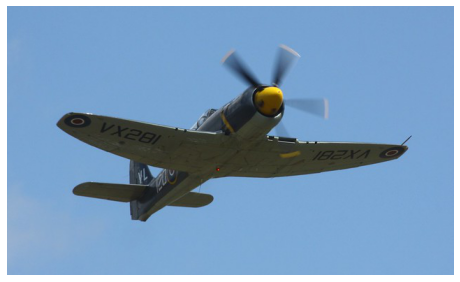

In [ ]:
caption_testImg(139)

Prediction:
LSTM: a UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN
GRU: a UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN
BLSTM: a UNKNOWN of a UNKNOWN UNKNOWN UNKNOWN UNKNOWN
BGRU: a UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN UNKNOWN
Trainable BLSTM: a vase of flowers sitting on a table
Trainable BGRU: a vase with a flower in it sitting on a table
Actual:
some orange flowers in a tall silver vase
orange red and white flowers in vases on tables
a small silver vase with some orange flowers in it
orange flowers UNKNOWN vases in the flower shop
a metal vase of flowers on top of a counter


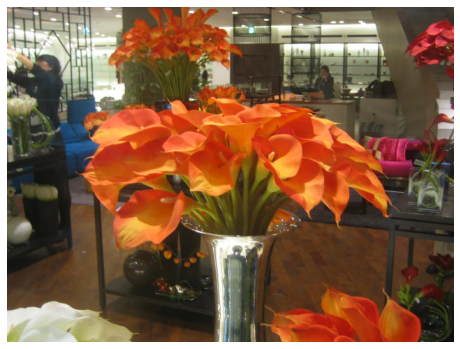

In [ ]:
caption_testImg(8)

Prediction:
LSTM: a man in a suit and tie standing next to a woman
GRU: a man in a suit and tie standing next to a woman
BLSTM: a man in a suit and tie is standing in front of a UNKNOWN
BGRU: a man in a suit and tie standing next to a woman
Trainable BLSTM: a man in a suit and tie is smiling
Trainable BGRU: a man in a suit and tie standing next to a UNKNOWN
Actual:
a group of people sitting side by side to take a photograph
a black and white photo of a group of people in UNKNOWN UNKNOWN
a big group people that are posing xFor a picture
a UNKNOWN of men and woman wearing UNKNOWN clothing
a black and white picture of a group of people


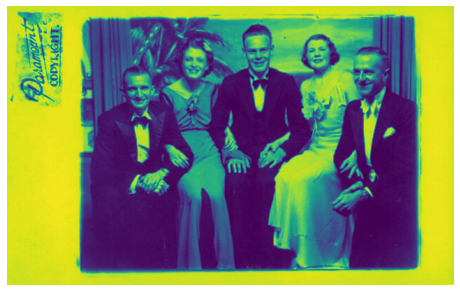

In [ ]:
caption_testImg(159)

Prediction:
LSTM: a man in a UNKNOWN UNKNOWN UNKNOWN a frisbee
GRU: a man UNKNOWN a frisbee in a grassy field
BLSTM: a zebra standing next to a UNKNOWN tree
BGRU: a zebra standing in a field next to a tree
Trainable BLSTM: a zebra standing in a field next to a tree
Trainable BGRU: a zebra standing next to a UNKNOWN zebra
Actual:
a field with various UNKNOWN and trees in the background
a group of zebras in a field by some trees
the group of zebras are in the field
zebras and UNKNOWN UNKNOWN living together on the UNKNOWN
many animals in a field with trees and bushes in the background


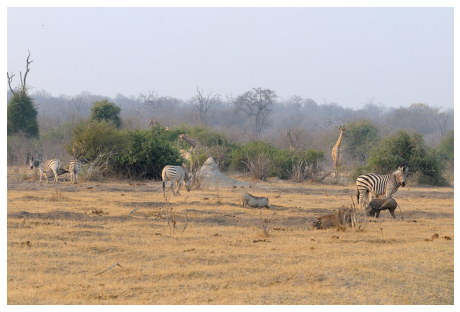

In [ ]:
caption_testImg(179)

Prediction:
LSTM: a man is UNKNOWN a UNKNOWN UNKNOWN UNKNOWN
GRU: a man is playing tennis on a tennis court
BLSTM: a desk with a computer and a laptop on it
BGRU: a desk with a laptop and a desktop computer
Trainable BLSTM: a desk with a laptop and a UNKNOWN
Trainable BGRU: a computer desk with a laptop and a desktop computer
Actual:
a desktop computer sitting on top of a wooden desk
a computer is UNKNOWN on on top of a desk
a desktop computer sits UNKNOWN a cluttered desk
a desk containing a computer monitor and keyboard
computer station with one computer and many UNKNOWN


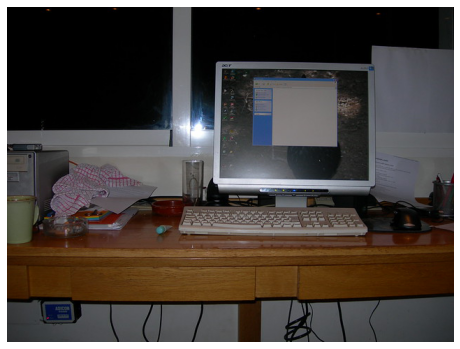

In [ ]:
caption_testImg(880)

Prediction:
LSTM: a man in a suit and tie standing next to a woman
GRU: a man in a suit and tie standing next to a woman
BLSTM: a man in a suit and tie is standing in front of a UNKNOWN
BGRU: a man in a suit and tie standing next to a woman
Trainable BLSTM: a man in a suit and tie is smiling
Trainable BGRU: a man in a suit and tie standing next to a UNKNOWN
Actual:
an old black and white photo of two men in suits
two men are UNKNOWN wearing suits in this UNKNOWN photo
a black and white photo of two young UNKNOWN next to each other
a man standing leaning on a man sitting
an old black and white photo of two men next to UNKNOWN


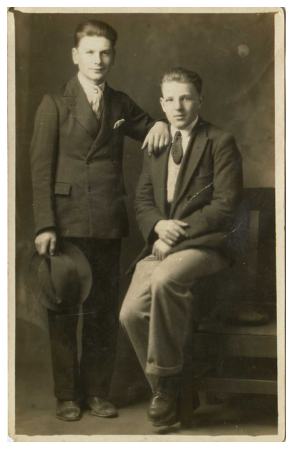

In [ ]:
caption_testImg(339)

Prediction:
LSTM: a woman swinging a tennis racquet at a tennis ball
GRU: a woman swinging a tennis racquet at a tennis ball
BLSTM: a woman playing tennis on a tennis court
BGRU: a man swinging a tennis racquet at a tennis ball
Trainable BLSTM: a man is playing tennis on a tennis court
Trainable BGRU: a woman UNKNOWN a tennis ball with her racket
Actual:
a man is serving in a game of tennis
a person standing on a tennis court hitting a tennis ball with a racquet
one tennis player jumps to hit the tennis ball on a court
four playing a UNKNOWN games of tennis on a tennis court


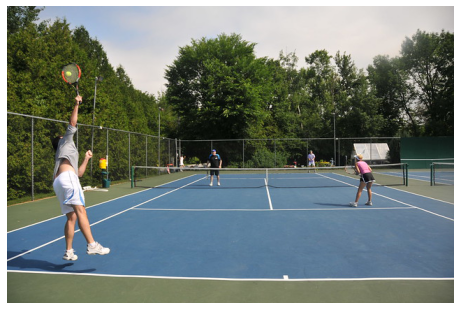

In [ ]:
caption_testImg(20000)

Prediction:
LSTM: a man riding a bike down a street next to a UNKNOWN
GRU: a man riding a bike down a street next to a woman
BLSTM: a man riding a bike down a street next to a tall building
BGRU: a man is riding a bike with a dog
Trainable BLSTM: a bathroom with a toilet and a sink
Trainable BGRU: a man riding a bike with a surfboard on top of it
Actual:
a man in white shirt on bicycle with a dog riding in the back
a man on a bicycle with a dog sitting in the back of the bike
an old photo of a person on a bike in a parking lot
a man and his dog riding on a bike
there is a man riding a bike with a dog on the back


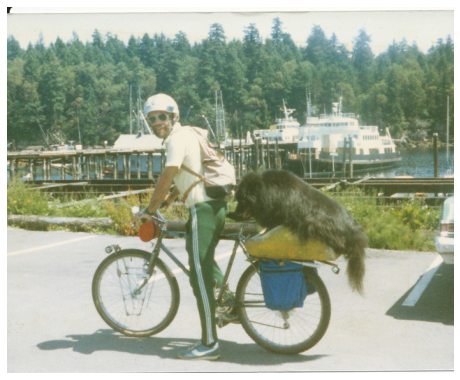

In [ ]:
caption_testImg(69)

Prediction:
LSTM: a train traveling down train tracks next to a building
GRU: a train traveling down tracks next to a train station
BLSTM: a train traveling down tracks next to a forest
BGRU: a train is traveling down the tracks near a building
Trainable BLSTM: a train is traveling down the tracks near a UNKNOWN
Trainable BGRU: a train traveling down train tracks next to a building
Actual:
a train moving along a track during the day
a train UNKNOWN by a road on a railroad track
yellow train engine UNKNOWN UNKNOWN cars past a UNKNOWN crossing
a large long train on a steel track
a yellow train engine pulling train cars over road


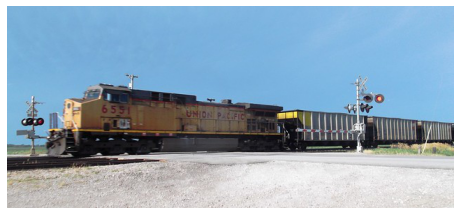

In [ ]:
caption_testImg(259)

Prediction:
LSTM: a man in a UNKNOWN UNKNOWN UNKNOWN a frisbee
GRU: a zebra standing in a field with a UNKNOWN
BLSTM: a zebra standing next to a UNKNOWN tree
BGRU: a zebra standing in a field next to a tree
Trainable BLSTM: a zebra standing in a field next to a tree
Trainable BGRU: a zebra standing next to a wooden fence
Actual:
a herd of zebras UNKNOWN around a UNKNOWN area
three zebras in an UNKNOWN feeding on a UNKNOWN ground
zebras that are hanging around and eating something off the ground
a couple of zebras that are out in a dirt field
two zebra stand on dirt in a fenced off area


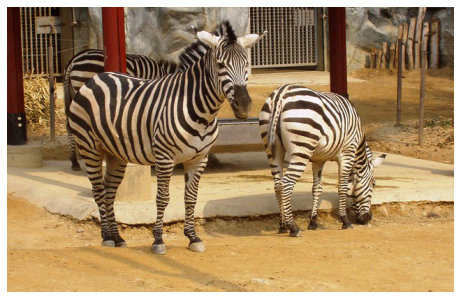

In [ ]:
caption_testImg(1071)

Prediction:
LSTM: a man riding a horse in a UNKNOWN
GRU: a man riding a horse drawn carriage on a beach
BLSTM: a man riding a horse on a beach
BGRU: a man riding a horse drawn carriage down a street
Trainable BLSTM: a horse drawn carriage riding down a street
Trainable BGRU: a man riding a horse drawn carriage with a horse
Actual:
a person riding a UNKNOWN and horse down the street
a small horse pulling a two UNKNOWN UNKNOWN
a house pulling a cart with UNKNOWN on it
a horse is pulling a carriage in the street
a horse UNKNOWN an UNKNOWN carriage on a UNKNOWN road


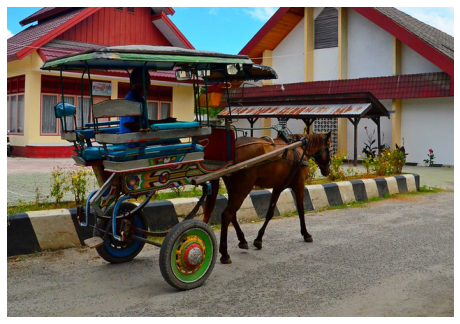

In [ ]:
caption_testImg(1075)

Prediction:
LSTM: a man is standing in front of a television
GRU: a man is playing tennis on a tennis court
BLSTM: a man is playing a video game xWhile
BGRU: a man is standing next to a woman
Trainable BLSTM: a man in a UNKNOWN shirt UNKNOWN a UNKNOWN
Trainable BGRU: a man is UNKNOWN a UNKNOWN UNKNOWN UNKNOWN
Actual:
a man UNKNOWN over a laptop computer next to UNKNOWN equipment
a man in a black shirt and black pants on a laptop in a UNKNOWN
two men UNKNOWN looking at the screen on a laptop
man drinking a beer on a white computer
two men working on a computer on a wooden table


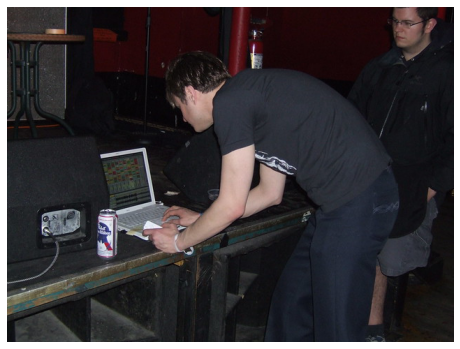

In [ ]:
caption_testImg(3155)

Prediction:
LSTM: a man riding a surfboard on a wave in the ocean
GRU: a man riding a wave on top of a surfboard
BLSTM: a man is riding a wave on a surfboard
BGRU: a man is UNKNOWN a soccer ball on a soccer field
Trainable BLSTM: a man riding a wave on top of a surfboard
Trainable BGRU: a man riding a wave on top of a surfboard
Actual:
two surfers on their boards on a UNKNOWN day
UNKNOWN boarder in middle of UNKNOWN water xWhile on board
a man riding on top of a UNKNOWN board in the ocean
a UNKNOWN is UNKNOWN xWhile another person lies on their board nearby


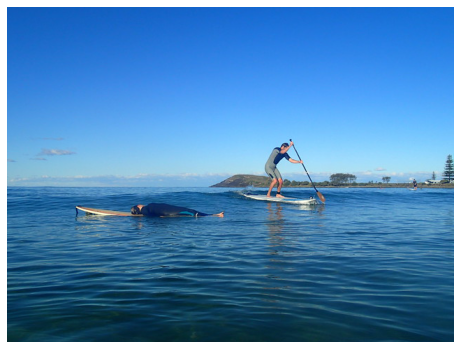

In [ ]:
caption_testImg(21420)

Prediction:
LSTM: a man is UNKNOWN a UNKNOWN UNKNOWN UNKNOWN
GRU: a laptop computer sitting on top of a desk
BLSTM: a laptop computer sitting on top of a desk
BGRU: a laptop computer sitting on top of a desk
Trainable BLSTM: a laptop computer sitting on top of a wooden desk
Trainable BGRU: a laptop computer sitting on top of a wooden desk
Actual:
a woman using a laptop computer on top of a wooden desk
two female hands and a black laptop and a camera and controller
a table with a camera a remote and a person using a laptop computer


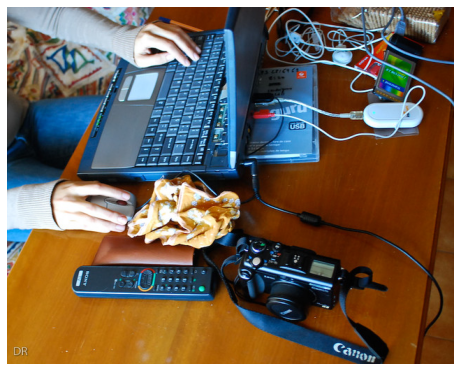

In [ ]:
caption_testImg(859)

Prediction:
LSTM: a man is playing frisbee on a beach
GRU: a man is UNKNOWN a frisbee in a park
BLSTM: a man is jumping a skateboard over a UNKNOWN
BGRU: a man is jumping a skateboard over a ramp
Trainable BLSTM: a man is UNKNOWN a frisbee in a field
Trainable BGRU: a man is riding a skateboard down a street
Actual:
a man on the side of the road holding a frisbee
a man standing on a park holding a white frisbee
a man with a ball of some UNKNOWN
man catching a frisbee xWhile outside his home
a man UNKNOWN UNKNOWN to xCatch a frisbee


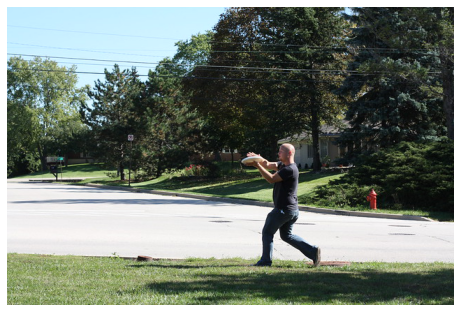

In [ ]:
caption_testImg(559)

Prediction:
LSTM: a man in a UNKNOWN UNKNOWN UNKNOWN a UNKNOWN
GRU: a man is UNKNOWN a UNKNOWN UNKNOWN UNKNOWN
BLSTM: a man is UNKNOWN a UNKNOWN UNKNOWN UNKNOWN
BGRU: a man is standing next to a woman
Trainable BLSTM: a man in a suit and tie is standing in front of a UNKNOWN
Trainable BGRU: a man is standing in front of a UNKNOWN
Actual:
a man and a woman standing next to each other in front of a crowd
a UNKNOWN couple UNKNOWN their wedding with their UNKNOWN
a large group of people UNKNOWN at a UNKNOWN
a man and woman UNKNOWN their glass xFor a UNKNOWN
a young couple in UNKNOWN UNKNOWN UNKNOWN UNKNOWN the crowd


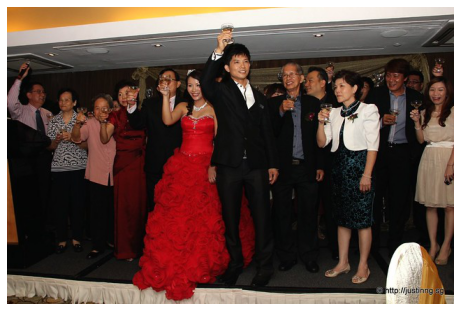

In [ ]:
caption_testImg(447)

Prediction:
LSTM: a man is playing a video game with a remote
GRU: a man is playing a video game with a remote controller
BLSTM: a man playing a video game xWhile others watch
BGRU: a man standing in a living room holding a wii remote
Trainable BLSTM: a man standing in a living room holding a game controller
Trainable BGRU: a man is playing a video game with a remote controller
Actual:
a man with UNKNOWN glasses who is holding a wii remote
a young man wearing glasses and a red shirt holding a small white device
a young man wearing a red UNKNOWN is holding his wii UNKNOWN
boy posing in a UNKNOWN UNKNOWN with his wii controller
boy with glasses and red shirt holding UNKNOWN


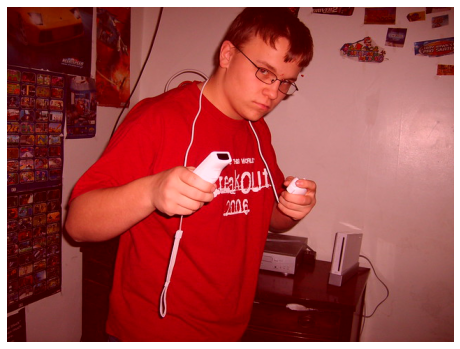

In [ ]:
caption_testImg(875)

Prediction:
LSTM: a man in a wet suit is playing frisbee
GRU: a man UNKNOWN a soccer ball with his UNKNOWN
BLSTM: a woman UNKNOWN a soccer ball with a tennis racquet
BGRU: a man is playing a game of soccer
Trainable BLSTM: a man UNKNOWN a soccer ball on a soccer field
Trainable BGRU: a man is playing a game of soccer
Actual:
a man standing next to another man xWhile UNKNOWN a soccer ball
two men in a soccer field UNKNOWN a ball
two soccer players UNKNOWN each other xFor the ball
two soccer players UNKNOWN to be UNKNOWN each other
two soccer players UNKNOWN against each other as they UNKNOWN to get to the ball


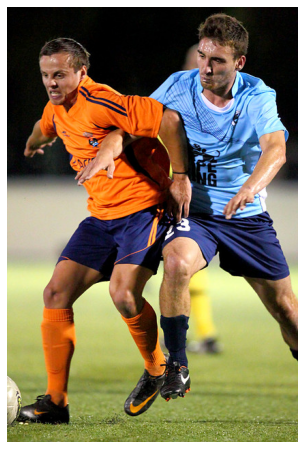

In [ ]:
caption_testImg(3069)

Prediction:
LSTM: a woman swinging a tennis racquet at a tennis ball
GRU: a woman swinging a tennis racquet at a tennis ball
BLSTM: a tennis player UNKNOWN to hit a tennis ball
BGRU: a woman hitting a tennis ball with a tennis racket
Trainable BLSTM: a woman playing tennis on a tennis court
Trainable BGRU: a woman UNKNOWN a tennis ball with her racket
Actual:
a kid is standing on a tennis court with a racket
a young girl playing tennis at a tennis court
a young girl playing tennis on an UNKNOWN court
a young girl standing on top of a tennis court holding a racquet
a kid holding a racket ready to UNKNOWN the ball


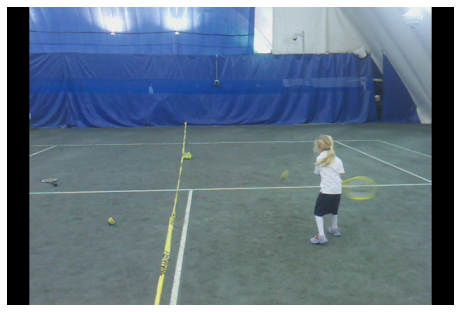

In [ ]:
caption_testImg(731)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# evaluate the skill of the model
def eval_model(act, pred):
  # get descriptions
  predicted = [i[0].split() for i in pred.values()]
  
  # get real captions
  actual = [ [ j.split() for j in m ] for m in actual_container.values() ]

  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


# BLEU Score Implementation

In [ ]:

def GenerateBatch(Test_Index, Test_Encodes,wordtoix, model,batch_size=281):
    ''' 
        Create Batches and Evaluate BLEU score
    '''
    actual_container={}
    pred_container={}
    TestDataset=tf.data.Dataset.from_tensor_slices((Test_Encodes,Test_Index))
    for batch in TestDataset.batch(255):
            feats = batch[0].numpy() #Indexes
            iteration = feats.shape[0]
            seq = np.tile(np.array([1] + [0]*16), (iteration, 1))
            for i in range(16):
                with tf.device("/cpu:0"): #BE CAREFUL, IF YOU USE GPU, THERE WILL BE MEMORY LEAK!!
                    pred = model.predict([feats, seq])
                seq[:, i+1] = np.argmax(pred, axis=1)
            for i in range(iteration):
                name = batch[1].numpy()[i][0].decode()
                #!!! If your keys are '.jpg' then do this. Otherwise, comment
                #nameID=int(name[:-4])
                pred_container[name] = Caption_GENERATE(seq[i],wordtoix)

    for d in TestDataset.take(Test_Encodes.shape[0]):
            name = d[1].numpy()[0].decode()
            nameID=int(name[:-4])
            cap=Fetch_Caption(nameID, test_imid, test_cap, wordtoix)
            actual_container[name] = Caption_GET(cap,wordtoix)  
    return actual_container, pred_container  

In [ ]:
from keras.models import load_model
import tensorflow as tf

model = load_model("v2_trainablebiGru.h5")
actual_container, pred_container= GenerateBatch(Test_Index, Test_Encodes, wordtoix, model, batch_size=281)

In [ ]:
import pickle #Call the function
print(os.getcwd())

# save to file
#pickle.dump(actual_container, open('actual_container.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_trainable_bilstm.pkl', 'wb'))
# save to file
#pickle.dump(actual_container, open('actual_container.pkl', 'wb'))
#pickle.dump(pred_container, open('pred_container_v2_lstmweights.pkl', 'wb'))
# save to file
#pickle.dump(actual_container, open('actual_container.pkl', 'wb'))
pickle.dump(pred_container, open('pred_container_v2_trainablebiGru.pkl', 'wb'))

In [ ]:
actual_container = pickle.load(open('actual_container.pkl', 'rb'))
pred_container_v2_trainable_bilstm = pickle.load(open('pred_container_v2_trainable_bilstm.pkl', 'rb'))
pred_container_v2_lstmweights = pickle.load(open('pred_container_v2_lstmweights.pkl', 'rb'))


{'0.jpg': ['a man with a red helmet on a small UNKNOWN on a dirt road',
  'man riding a motor bike on a dirt road on the UNKNOWN',
  'a man riding on the back of a motorcycle'],
 '1.jpg': ['a woman wearing a net on her head cutting a cake',
  'a woman cutting a large white UNKNOWN cake',
  'a woman wearing a hair net cutting a large UNKNOWN cake',
  'there is a woman that is cutting a white cake',
  'a woman UNKNOWN a cake with the back of a UNKNOWN knife'],
 '10.jpg': ['two UNKNOWN in a restaurant kitchen preparing food',
  'two UNKNOWN are cooking the food someone UNKNOWN at this restaurant',
  'the UNKNOWN is cooking with UNKNOWN on the stove next to an oven',
  'two men that are standing in a kitchen',
  'two UNKNOWN are near the stove in a stainless steel kitchen'],
 '100.jpg': ['a horse drawn carriage is parked along the curb',
  'a horse drawn carriage is in front of an old large building',
  'a pair of horses carrying a carriage that is parked by a street',
  'a horse drawn car

In [ ]:
pred_container_v2_lstmweights['1178.jpg']

['a UNKNOWN UNKNOWN plane flying through the air']

In [ ]:
import os
import pickle
os.chdir("/content/drive/MyDrive/EE443 Project")
actual_container = pickle.load(open('actual_container.pkl', 'rb'))
predicted_container = pickle.load(open('pred_container_v2_trainable_bilstm.pkl', 'rb'))


In [ ]:
import numpy as np
print("Bidirectional LSTM with trainable embedding")
eval_model(actual_container, predicted_container)

Bidirectional LSTM with trainable embedding
BLEU-1: 0.567547
BLEU-2: 0.371485
BLEU-3: 0.232320
BLEU-4: 0.144709


In [ ]:
trainablebigru_predicted = pickle.load(open('pred_container_v2_trainablebiGru.pkl', 'rb'))
print("Bidirectional GRU with trainable embedding")
eval_model(actual_container, trainablebigru_predicted)

Bidirectional GRU with trainable embedding
BLEU-1: 0.545788
BLEU-2: 0.350521
BLEU-3: 0.219726
BLEU-4: 0.137411


In [ ]:
print("LSTM")
eval_model(actual_container, lstm_predicted)

LSTM
BLEU-1: 0.547999
BLEU-2: 0.354344
BLEU-3: 0.218182
BLEU-4: 0.132305


In [ ]:
gru_predicted = pickle.load(open('pred_container_v2_gru.pkl', 'rb'))
print("GRU")
eval_model(actual_container, gru_predicted)

GRU
BLEU-1: 0.537164
BLEU-2: 0.342924
BLEU-3: 0.212018
BLEU-4: 0.129264


In [ ]:
bigru_predicted = pickle.load(open('pred_container_v2_biGRU.pkl', 'rb'))
print("Bidirectional GRU")
eval_model(actual_container, bigru_predicted)

Bidirectional GRU
BLEU-1: 0.544169
BLEU-2: 0.349859
BLEU-3: 0.219803
BLEU-4: 0.138252


In [ ]:
bilstm_predicted = pickle.load(open('pred_container_v2_bilstm.pkl', 'rb'))
print("Bidirectional LSTM")
eval_model(actual_container, bilstm_predicted)

Bidirectional LSTM
BLEU-1: 0.549658
BLEU-2: 0.355719
BLEU-3: 0.224638
BLEU-4: 0.140640
